<a href="https://colab.research.google.com/github/NiceNewton/NiceNewton/blob/main/Semantic_Search_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install sentence-transformers faiss-cpu numpy pandas matplotlib datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 38.0 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import faiss
from typing import List, Dict, Tuple
import time
import re
import torch

In [5]:
abstracts = [
    {
        "id": 1,
        "title": "Deep Learning for Natural Language Processing",
        "abstract": "This paper explores recent advances in deep learning models for natural language processing tasks. We review transformer architectures including BERT, GPT, and T5, and analyze their performance on various benchmarks including question answering, sentiment analysis, and text classification."
    },
    {
        "id": 2,
        "title": "Climate Change Impact on Marine Ecosystems",
        "abstract": "Rising ocean temperatures and acidification are severely impacting coral reefs and marine biodiversity. This study presents data collected over a 10-year period, demonstrating accelerated decline in reef ecosystems and proposing conservation strategies to mitigate further damage."
    },
    {
        "id": 3,
        "title": "Advancements in mRNA Vaccine Technology",
        "abstract": "The development of mRNA vaccines represents a breakthrough in immunization technology. This review discusses the mechanism of action, stability improvements, and clinical efficacy of mRNA platforms, with special attention to their rapid deployment during the COVID-19 pandemic."
    },
    {
        "id": 4,
        "title": "Quantum Computing Algorithms for Optimization Problems",
        "abstract": "Quantum computing offers potential speedups for solving complex optimization problems. This paper presents quantum algorithms for combinatorial optimization and compares their theoretical performance with classical methods on problems including traveling salesman and maximum cut."
    },
    {
        "id": 5,
        "title": "Sustainable Urban Planning Frameworks",
        "abstract": "This research proposes frameworks for sustainable urban development that integrate renewable energy systems, efficient public transportation networks, and green infrastructure. Case studies from five cities demonstrate reductions in carbon emissions and improvements in quality of life metrics."
    },
    {
        "id": 6,
        "title": "Neural Networks for Computer Vision",
        "abstract": "Convolutional neural networks have revolutionized computer vision tasks. This paper examines recent architectural innovations including residual connections, attention mechanisms, and vision transformers, evaluating their performance on image classification, object detection, and segmentation benchmarks."
    },
    {
        "id": 7,
        "title": "Blockchain Applications in Supply Chain Management",
        "abstract": "Blockchain technology enables transparent and secure tracking of goods throughout supply chains. This study analyzes implementations across food, pharmaceutical, and retail industries, quantifying improvements in traceability, reduction in counterfeit products, and enhanced consumer trust."
    },
    {
        "id": 8,
        "title": "Genetic Factors in Autoimmune Disorders",
        "abstract": "This research identifies key genetic markers associated with increased susceptibility to autoimmune conditions. Through genome-wide association studies of 15,000 patients, we identified novel variants that influence immune system regulation and may serve as targets for personalized therapeutic approaches."
    },
    {
        "id": 9,
        "title": "Reinforcement Learning for Robotic Control Systems",
        "abstract": "Deep reinforcement learning enables robots to learn complex manipulation tasks through trial and error. This paper presents a framework that combines model-based planning with policy gradient methods to achieve sample-efficient learning of dexterous manipulation skills."
    },
    {
        "id": 10,
        "title": "Microplastic Pollution in Freshwater Systems",
        "abstract": "This study quantifies microplastic contamination across 30 freshwater lakes and rivers, identifying primary sources and transport mechanisms. Results indicate correlation between population density and contamination levels, with implications for water treatment policies and plastic waste management."
    }
]


papers_df = pd.DataFrame(abstracts)
print(f"Dataset loaded with {len(papers_df)} scientific papers")
papers_df[["id", "title"]]

Dataset loaded with 10 scientific papers


,id,title
0,1,Deep Learning for Natural Language Processing
1,2,Climate Change Impact on Marine Ecosystems
2,3,Advancements in mRNA Vaccine Technology
3,4,Quantum Computing Algorithms for Optimization ...
4,5,Sustainable Urban Planning Frameworks
5,6,Neural Networks for Computer Vision
6,7,Blockchain Applications in Supply Chain Manage...
7,8,Genetic Factors in Autoimmune Disorders
8,9,Reinforcement Learning for Robotic Control Sys...
9,10,Microplastic Pollution in Freshwater Systems


In [6]:
model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)
print(f"Loaded model: {model_name}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loaded model: all-MiniLM-L6-v2


In [7]:
documents = papers_df['abstract'].tolist()
document_embeddings = model.encode(documents, show_progress_bar=True)


print(f"Generated {len(document_embeddings)} embeddings with dimension {document_embeddings.shape[1]}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated 10 embeddings with dimension 384


In [8]:
dimension = document_embeddings.shape[1]


index = faiss.IndexFlatL2(dimension)
index.add(np.array(document_embeddings).astype('float32'))


print(f"Created FAISS index with {index.ntotal} vectors")

Created FAISS index with 10 vectors


In [9]:
def semantic_search(query: str, top_k: int = 3) -> List[Dict]:
    """
    Search for documents similar to query


    Args:
        query: Text to search for
        top_k: Number of results to return


    Returns:
        List of dictionaries containing document info and similarity score
    """
    query_embedding = model.encode([query])


    distances, indices = index.search(np.array(query_embedding).astype('float32'), top_k)


    results = []
    for i, idx in enumerate(indices[0]):
        results.append({
            'id': papers_df.iloc[idx]['id'],
            'title': papers_df.iloc[idx]['title'],
            'abstract': papers_df.iloc[idx]['abstract'],
            'similarity_score': 1 - distances[0][i] / 2
        })


    return results

In [10]:
test_queries = [
    "How do transformers work in natural language processing?",
    "What are the effects of global warming on ocean life?",
    "Tell me about COVID vaccine development",
    "Latest algorithms in quantum computing",
    "How can cities reduce their carbon footprint?"
]


for query in test_queries:
    print("\n" + "="*80)
    print(f"Query: {query}")
    print("="*80)


    results = semantic_search(query, top_k=3)


    for i, result in enumerate(results):
        print(f"\nResult #{i+1} (Score: {result['similarity_score']:.4f}):")
        print(f"Title: {result['title']}")
        print(f"Abstract snippet: {result['abstract'][:150]}...")


Query: How do transformers work in natural language processing?

Result #1 (Score: 0.5166):
Title: Deep Learning for Natural Language Processing
Abstract snippet: This paper explores recent advances in deep learning models for natural language processing tasks. We review transformer architectures including BERT,...

Result #2 (Score: 0.2008):
Title: Neural Networks for Computer Vision
Abstract snippet: Convolutional neural networks have revolutionized computer vision tasks. This paper examines recent architectural innovations including residual conne...

Result #3 (Score: 0.0594):
Title: Advancements in mRNA Vaccine Technology
Abstract snippet: The development of mRNA vaccines represents a breakthrough in immunization technology. This review discusses the mechanism of action, stability improv...

Query: What are the effects of global warming on ocean life?

Result #1 (Score: 0.5669):
Title: Climate Change Impact on Marine Ecosystems
Abstract snippet: Rising ocean temperatures and acid

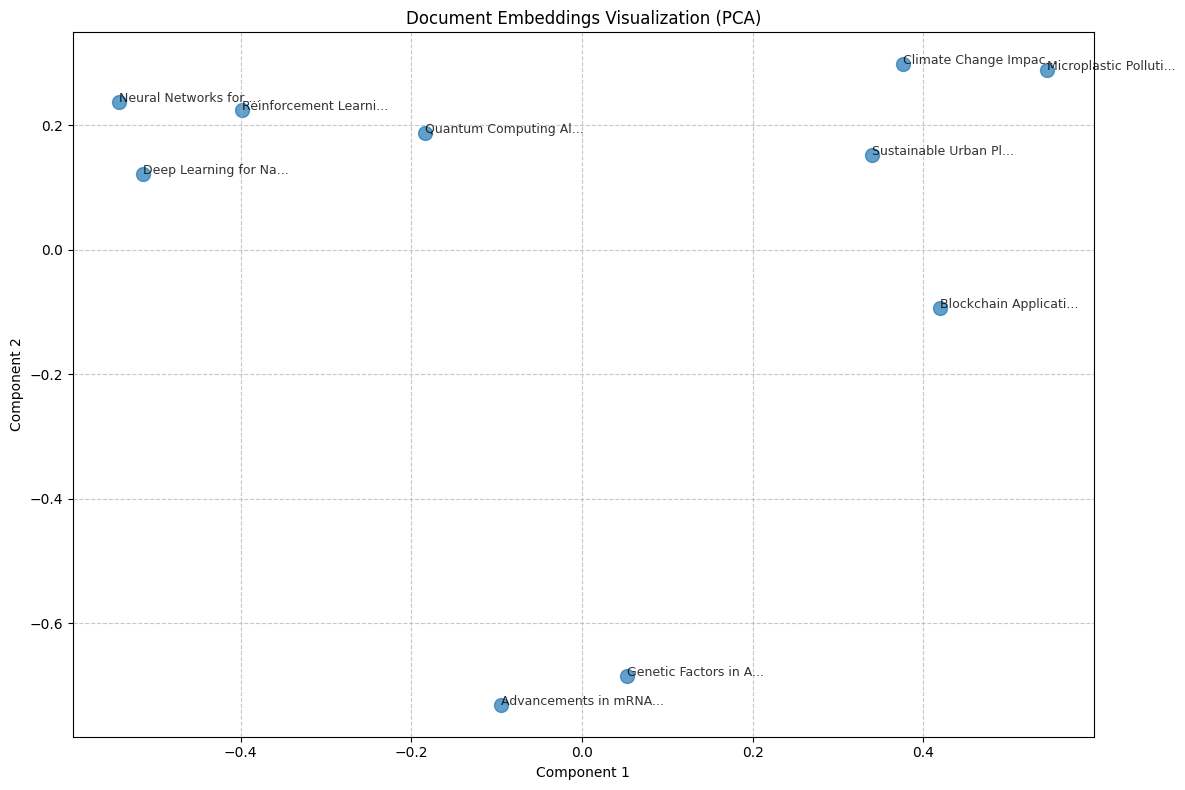

In [11]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(document_embeddings)


plt.figure(figsize=(12, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=100, alpha=0.7)


for i, (x, y) in enumerate(reduced_embeddings):
    plt.annotate(papers_df.iloc[i]['title'][:20] + "...",
                 (x, y),
                 fontsize=9,
                 alpha=0.8)


plt.title('Document Embeddings Visualization (PCA)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets


def run_search(query_text):
    clear_output(wait=True)


    display(HTML(f"<h3>Query: {query_text}</h3>"))


    start_time = time.time()
    results = semantic_search(query_text, top_k=5)
    search_time = time.time() - start_time


    display(HTML(f"<p>Found {len(results)} results in {search_time:.4f} seconds</p>"))


    for i, result in enumerate(results):
        html = f"""
        <div style="margin-bottom: 20px; padding: 15px; border: 1px solid #ddd; border-radius: 5px;">
            <h4>{i+1}. {result['title']} <span style="color: #007bff;">(Score: {result['similarity_score']:.4f})</span></h4>
            <p>{result['abstract']}</p>
        </div>
        """
        display(HTML(html))


search_box = widgets.Text(
    value='',
    placeholder='Type your search query here...',
    description='Search:',
    layout=widgets.Layout(width='70%')
)


search_button = widgets.Button(
    description='Search',
    button_style='primary',
    tooltip='Click to search'
)


def on_button_clicked(b):
    run_search(search_box.value)


search_button.on_click(on_button_clicked)


display(widgets.HBox([search_box, search_button]))